# PACO algorithm of Flasseur et al (2018)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


def rotateImage(image, angle):
    
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def gaussian2d(x,y,A, sigma):
    return A*np.exp(-(x**2+y**2)/(2*sigma**2))

def cart2pol(x,y):
    """
    Takes cartesian (2D) coordinates and transforms them into polar.
    """
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(r, phi):
    x = r*np.cos(phi)
    y = r*np.sin(phi)
    return (x,y)

## Create dummy data


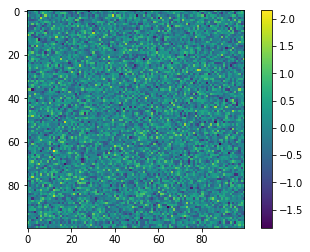

In [2]:
angles = np.array([0, 30, 45, 60, 90])

sigma = 0.5 # gaussian noise

mean = 0

images = [np.reshape(np.random.normal(mean, sigma, 10000), (100,100)) for j in range(len(angles))]

plt.imshow(images[1])
plt.colorbar()

Text(0.5, 1.0, '90 deg rotation')

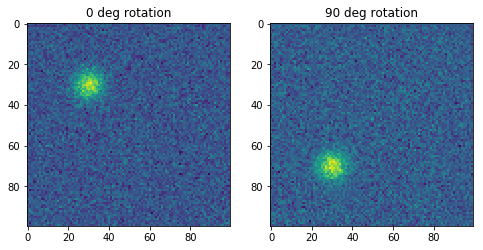

In [3]:
xx, yy = np.meshgrid(np.arange(-30, 70),np.arange(-30, 70))
s = gaussian2d(xx,yy,4, 5)
images_signal = [i + s for i in images]
rot_images = [rotateImage(images_signal[j], angles[j]) for j in range(len(images_signal))]
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(8,6))
ax[0].imshow(rot_images[0])
ax[0].set_title("0 deg rotation")
ax[1].imshow(rot_images[-1])
ax[1].set_title("90 deg rotation")


## PACO

### Patches extraction

In [4]:
def get_patch(img_sequence, px, k):
    """
    gets patch at given pixel with size k for the given img sequence
    """
    nx, ny = np.shape(img_sequence[0])[:2]
    if px[0]+k > nx or px[0]-k < 0 or px[1]+k > ny or px[1]-k < 0:
        print("pixel out of range")
        return None
    patch = np.array([img_sequence[i][px[0]-k:px[0]+k, px[1]-k:px[1]+k] for i in range(len(img_sequence))])
    return patch

def plot_patches(patch, vmax=5):
    dim = len(patch)
    n = int(np.ceil(np.sqrt(dim)))
    m = int(np.ceil(dim/n))
    fig, ax = plt.subplots(nrows=m, ncols=n, figsize=(8,6))
    ax = ax.flatten()
    #ax = ax[:dim+1]
    for i in range(dim):
        ax[i].imshow(patch[i], vmax=vmax)
    return    

(5, 20, 20)


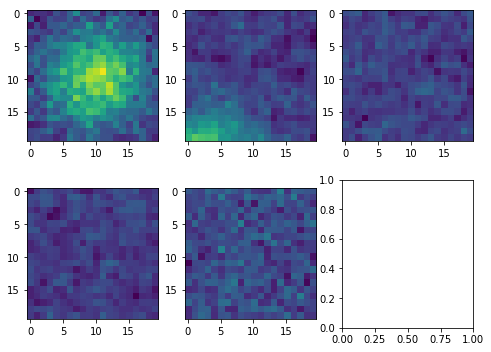

In [16]:
patch3030 = get_patch(rot_images, px=(30,30), k=10)
print(patch3030.shape)
plot_patches(patch3030, vmax =5)

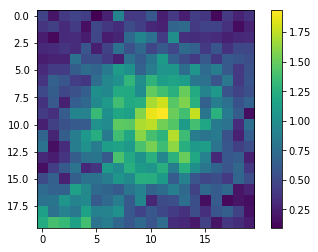

In [17]:
var = np.std(patch3030, axis=0)
plt.imshow(var)
plt.colorbar()

### Definition of estimators

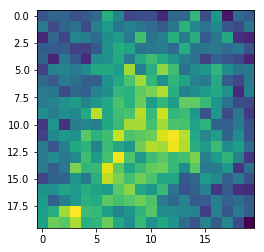

In [18]:
plt.imshow( np.mean(patch3030, axis=0))

In [19]:
def h_theta(n, model, **kwargs):
    return model(n, **kwargs)

def Chat(rho, S, F):
    return (1-rho)*S + rho*F

def Shat(r, m, T):
    return (1/T)*np.sum([np.dot((p-m),(p-m).T) for p in r], axis=0)

def Fhat(S):
    return np.diag(np.diag(S))

def rho_hat(S, T):
    return (np.trace(np.dot(S,S)) + np.trace(S)**2 - 2*np.sum(np.array([d**2 for d in np.diag(S)])))/((T+1)*(np.trace(np.dot(S,S))**2-np.sum(np.array([d**2 for d in np.diag(S)]))))

def al(hfl, Cfl_inv):
    return np.dot(hfl.T, np.dot(Cfl_inv, hfl))

def bl(hfl, Cfl_inv, r_fl, m_fl):
    return np.dot(hfl.T, np.dot(Cfl_inv, (r_fl-m_fl)))


def gaussian2d_model(n,sigma):
    dim = int(n/2)
    x, y = np.meshgrid(np.arange(-dim, dim), np.arange(-dim, dim))
    return np.exp(-((x+0.5)**2+(y+0.5)**2)/(2*sigma**2))     

def PACO(img_sequence, angles, phi0):
    N = np.shape(img_sequence[0])[0]
    dim = (N/2)
    x, y = np.meshgrid(np.arange(-dim, dim), np.arange(-dim, dim))
    phi0 = (x[phi0[0], phi0[1]], y[phi0[0], phi0[1]])

    r, theta = cart2pol(x,y)
    r0, theta0 = cart2pol(phi0[0], phi0[1])


    angles_rad = np.array([a*np.pi/180 for a in angles])+theta0

    angles_ind = [[r.flatten()[(np.abs(r.flatten() - r0)).argmin()], theta.flatten()[(np.abs(theta.flatten() - phi)).argmin()]] for phi in angles_rad]
    angles_pol = np.array(list(zip(*angles_ind)))
    angles_px = np.array(pol2cart(angles_pol[0], angles_pol[1]))+dim
    
    

100
(-20.0, -20.0)


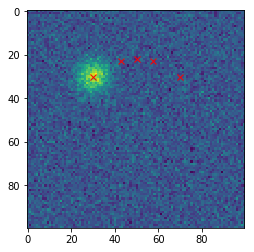

In [32]:
N = np.shape(rot_images[0])[0]
print(N)
phi0 = (30,30)
dim = (N/2)
x, y = np.meshgrid(np.arange(-dim, dim), np.arange(-dim, dim))
phi0 = (x[phi0[0], phi0[1]], y[phi0[0], phi0[1]])
print(phi0)
#x+=0.5
#y+=0.5
r, theta = cart2pol(x,y)
r0, theta0 = cart2pol(phi0[0], phi0[1])


angles_rad = np.array([a*np.pi/180 for a in angles])+theta0

angles_ind = [[r.flatten()[(np.abs(r.flatten() - r0)).argmin()], theta.flatten()[(np.abs(theta.flatten() - phi)).argmin()]] for phi in angles_rad]
angles_pol = np.array(list(zip(*angles_ind)))

angles_px = np.array(pol2cart(angles_pol[0], angles_pol[1]))+dim

plt.imshow(rot_images[0])
plt.plot(angles_px[0], angles_px[1], 'rx')

In [21]:
print(r0, x.flatten()[1034])

28.284271247461902 -16.0


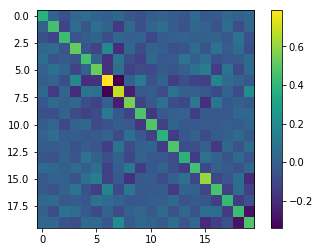

In [22]:
T = 5
m = np.mean(patch3030, axis=0)
S = Shat(patch3030, m, T)
rho = rho_hat(S, T)
F = Fhat(S)
C = Chat(rho, S, F)
Cinv = np.linalg.inv(C)
plt.imshow(Cinv)
plt.colorbar()

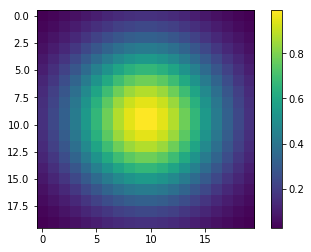

In [23]:
h = h_theta(20, gaussian2d_model, sigma=5)
plt.imshow(h)
plt.colorbar()

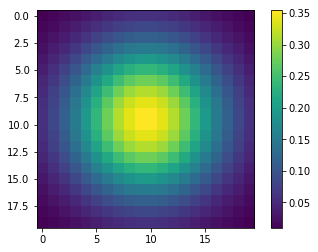

In [24]:
a = np.sum([al(h, Cinv) for r in patch3030],axis=0)
plt.imshow(a)
plt.colorbar()

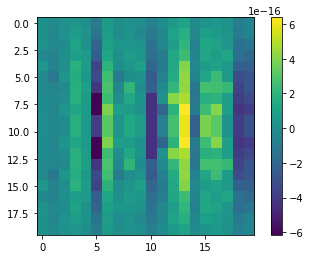

In [25]:
b = np.sum([bl(h, Cinv, p, m) for p in patch3030], axis=0)
plt.imshow(b)
plt.colorbar()

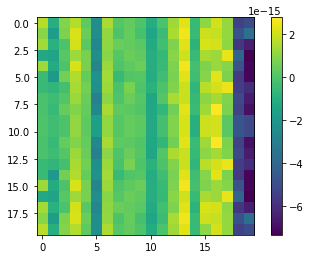

In [26]:
plt.imshow(b/a)
plt.colorbar()